In [1]:
import numpy as np
import os
import cv2
from PIL import Image
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torch.optim import Adam
import matplotlib
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    print("GPU is available")
    device = torch.device("cuda")
else:
    print("GPU is not available, using CPU instead")
    device = torch.device("cpu")

GPU is available


In [2]:
! pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 964.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=1edc00d4578f390bd40d594fb1d344bfd9ca371f02acefdbee1baa9d46360b2f
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=33f868d6379a0ab34aa121aacc648b44a03d2e1cc68c6edd600de582140e90e9
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficie

In [3]:
classes = ['Background','Other trees', 'Maple (Acer pseudoplatanus)',
           'Beech (Fagus sylvatica)',
           'Ash (Fraxinus excelsior)',
           'Oak (Quercus sp.)',
           'Deadwood',
           'Fir (Abies alba)',
           'Larch (Larix decidua)',
           'Spruce (Picea abies)',
           'Pine (Pinus sylvestris)',
           'Douglas fir (Pseudotsuga meziesii)',
           'Birch (Betula pendula)']

In [4]:
class TreeDataset(Dataset):
    def __init__(self, images_dir, masks_dir, classes, device):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.classes = classes
        self.K = len(classes)
        self.device = device

        # Define the transformation to resize the image to 512x512
        self.image_transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor()
        ])
        self.mask_transform = transforms.Compose([
            transforms.Resize((512, 512), interpolation=transforms.InterpolationMode.NEAREST),
        ])
        # Read images and masks using the read_files function
        images_list, masks_list = self.read_files(num_files=80)
        self.images = [img_file for img_file in images_list]
        self.masks = self.parse_annotation(masks_list)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image and mask tensors
        image = self.images[idx]
        mask = self.masks[idx]
        # Apply transformations
        image = self.image_transform(image)
        mask = self.mask_transform(mask)
        image = image.to(self.device)
        mask = mask.to(self.device)
        return image, mask

    def read_files(self, num_files):
        # Get a list of tiff files in the directories
        image_files = [f for f in os.listdir(self.images_dir) if f.endswith('.jpg')]
        mask_files = [f for f in os.listdir(self.masks_dir) if f.endswith('.jpg')]
        
        # Extract common part of filenames for sorting
        image_common_part = [f.split('_', 1)[1] for f in image_files]
        mask_common_part = [f.split('_', 1)[1] for f in mask_files]
        # Sort the lists based on the common part
        image_files_sorted = [img for _, img in sorted(zip(image_common_part, image_files))]
        mask_files_sorted = [mask for _, mask in sorted(zip(mask_common_part, mask_files))]
        
        # Limit the number of files
        image_files_sorted = image_files_sorted[:num_files]
        mask_files_sorted = mask_files_sorted[:num_files]
        # Initialize lists to store image arrays and mask arrays
        images = []
        masks = []

        # Loop through image files
        for img_file, mask_file in zip(image_files_sorted, mask_files_sorted):
            # Construct paths for image and mask files
            img_path = os.path.join(self.images_dir, img_file)
            mask_path = os.path.join(self.masks_dir, mask_file)
            # Read image
            img = cv2.imread(img_path)
            img_norm = img / 255.0  # Normalize
            img = Image.fromarray(img)
            # Read mask
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            masks.append(mask)
            images.append(img)
        return images, masks

    def create_binary_masks(self, mask):
        unique_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
        binary_masks = []
        for value in unique_values:
            # Create a binary mask where pixels with the current value are set to 255 (white) and others to 0 (black)
            binary_mask = np.where(mask == value, 255, 0).astype(np.uint8)
            # Apply morphological erosion to remove borders 
            kernel = np.ones((3, 3), np.uint8)
            binary_mask = cv2.erode(binary_mask, kernel, iterations=1)
            binary_masks.append(binary_mask)
        return binary_masks

    def parse_annotation(self, annt):
        parsed = []
        for mask in annt:
            bin_mask = self.create_binary_masks(mask)
            # Convert list of NumPy arrays to a single NumPy array
            stacked_masks_arr = np.stack(bin_mask, axis=0)
            tensor_mask = torch.tensor(stacked_masks_arr, dtype=torch.float32)
            parsed.append(tensor_mask)
        return parsed

In [5]:
# The whole pre-processed (divided in patches and class-balanced) dataset is 100 images
## train dataset consists of 80 images/masks
## test dataset consists of 20 images/masks
train_val_dataset = TreeDataset('/kaggle/input/multiclass-tree-species-segmentation/train/train_images', '/kaggle/input/multiclass-tree-species-segmentation/train/train_masks', classes=classes, device=device)
test_dataset  = TreeDataset('/kaggle/input/multiclass-tree-species-segmentation/test/test_images', '/kaggle/input/multiclass-tree-species-segmentation/test/test_masks', classes=classes, device=device)

#loading dataset train 60%, val 20% , test 20%
train_size = int(len(train_val_dataset)*0.75)  # 60% for training
val_size = int(len(train_val_dataset)*0.25) # 20% for validation
# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

In [6]:
# Create DataLoader instances for training, validation, and testsets
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [7]:
def visualise_with_masks(image, mask, pred_mask=None):
    if isinstance(image, torch.Tensor):
        image = image.cpu().permute(1, 2, 0).numpy()
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu()
        mask = np.argmax(mask.permute(1, 2, 0).numpy(), axis=2)
    if isinstance(pred_mask, torch.Tensor):
        pred_mask = pred_mask.cpu()
        pred_mask = np.argmax(pred_mask.permute(1, 2, 0).numpy(), axis=2)
    n_plots = 3
    plt.figure(figsize=(10,10))
    norm = matplotlib.colors.Normalize(vmin=0, vmax=len(classes)) # Fix the color mapping to classes
    # plotting image
    plt.subplot(1, n_plots, 1)
    plt.imshow(image, cmap='viridis')
    plt.axis('off')
    plt.title(f'Original Image {image.shape}')
    # plotting mask
    plt.subplot(1, n_plots, 2)
    plt.imshow(mask, cmap='viridis', norm=norm)
    plt.axis('off')
    plt.title('Mask')
    # plotting predicted mask
    if isinstance(pred_mask, np.ndarray):
        plt.subplot(1, n_plots, 3)
        plt.imshow(pred_mask, cmap='viridis', norm=norm)
        plt.axis('off')
        plt.title('Predicted Mask')
    plt.tight_layout()
    plt.show()

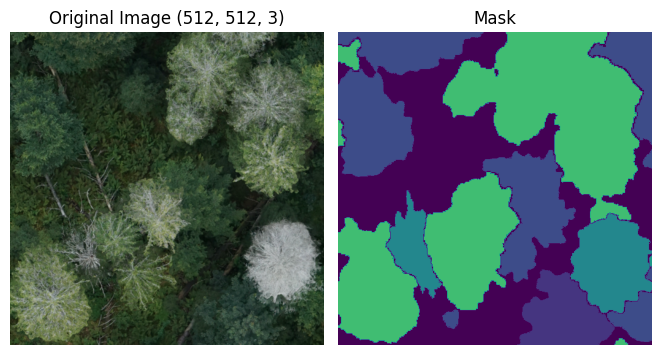

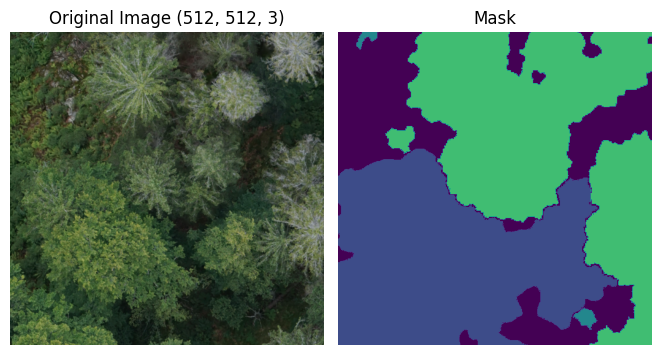

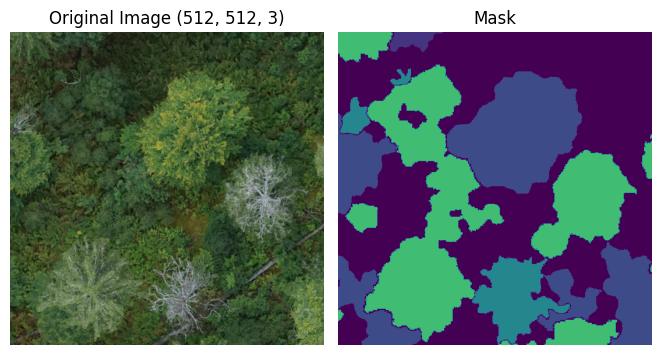

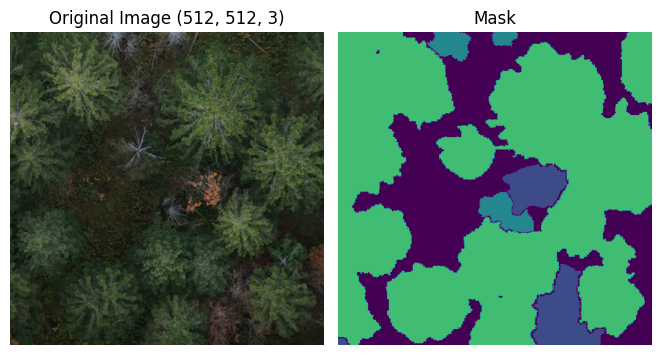

In [8]:
# Let's visualise 1 batch (8 images/masks) 
counter = 0
for images, masks in test_loader:
    for img, mask in zip(images, masks):
        visualise_with_masks(img, mask)
        counter += 1
    if counter >= 1:
        break

In [9]:
def fit(model, loss_func, train_loader, val_loader, n_epochs):
    history = {'loss': [], 'val_loss': []}

    for epoch in range(n_epochs):
        # initialise losses for logging
        epoch_loss, val_epoch_loss = 0.0, 0.0

        model.train()
        for images, targets in train_loader:
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()   # reseting gradients

            # Forward pass
            outputs = model(images)

            loss = loss_func(outputs, targets)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        model.eval()
        with torch.inference_mode():
            for images, targets in val_loader:
                images, targets = images.to(device), targets.to(device)

          # Forward pass only
            outputs = model(images)
            loss = loss_func(outputs, targets)

            val_epoch_loss += loss.item()

        history['loss'].append(epoch_loss/len(train_loader))
        history['val_loss'].append(val_epoch_loss/len(val_loader))
        print(f"Epoch {epoch + 1}, Loss: {history['loss'][-1]}, Val loss: {history['val_loss'][-1]}")
    return history

In [10]:
import segmentation_models_pytorch as smp

segment_model = smp.Unet(
    encoder_name='resnet34',        # backbone encoder architecture
    encoder_weights='imagenet',     # pre-trained weights
    in_channels=3,                   # number of input channels
    classes=len(classes) )

segment_model.train()
segment_model = segment_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 199MB/s]


In [11]:
segmentation_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(segment_model.parameters(), lr=0.001)

In [12]:
history = fit(segment_model, segmentation_loss, train_loader, val_loader, 20)

Epoch 1, Loss: 627.4647369384766, Val loss: 901.921484375
Epoch 2, Loss: 480.80701446533203, Val loss: 2042.4689453125
Epoch 3, Loss: 401.7931137084961, Val loss: 4739.98203125
Epoch 4, Loss: 352.6966552734375, Val loss: 4303.256640625
Epoch 5, Loss: 326.14611053466797, Val loss: 96.7817626953125
Epoch 6, Loss: 282.989688873291, Val loss: 104.17066650390625
Epoch 7, Loss: 268.43918228149414, Val loss: 111.25941162109375
Epoch 8, Loss: 247.04472732543945, Val loss: 81.62625732421876
Epoch 9, Loss: 234.84842681884766, Val loss: 95.21234130859375
Epoch 10, Loss: 205.57496643066406, Val loss: 88.67435302734376
Epoch 11, Loss: 196.1351547241211, Val loss: 96.24218139648437
Epoch 12, Loss: 193.6895294189453, Val loss: 52.36627197265625
Epoch 13, Loss: 176.89716339111328, Val loss: 63.9058837890625
Epoch 14, Loss: 162.06862258911133, Val loss: 31.16292724609375
Epoch 15, Loss: 153.15016174316406, Val loss: 32.06442565917969
Epoch 16, Loss: 158.01305961608887, Val loss: 71.63200073242187
Epoch

In [13]:
def plot_history(history):
    # Plot training & validation loss values
    plt.figure(figsize=(12, 5))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

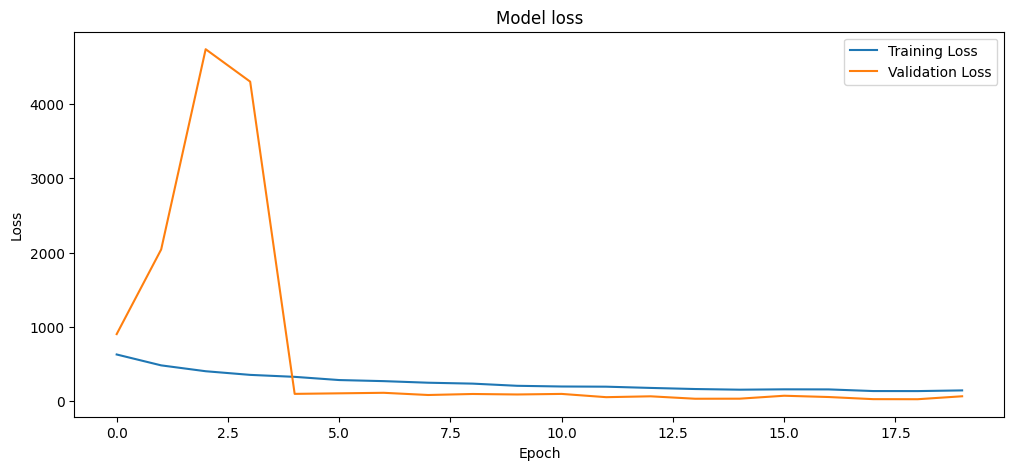

In [14]:
plot_history(history)

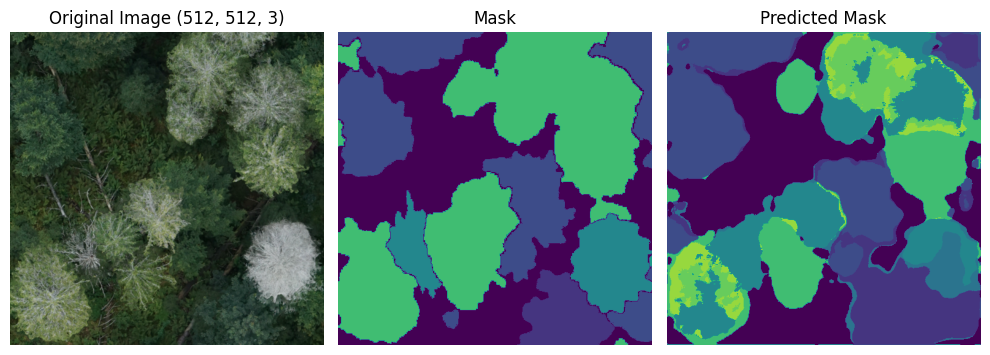

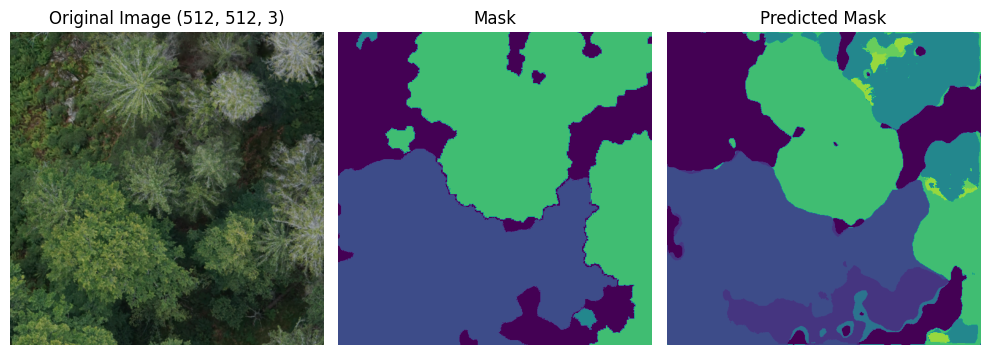

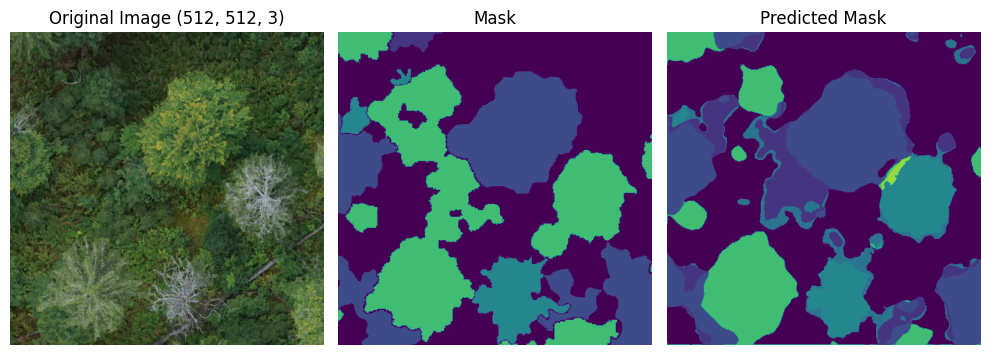

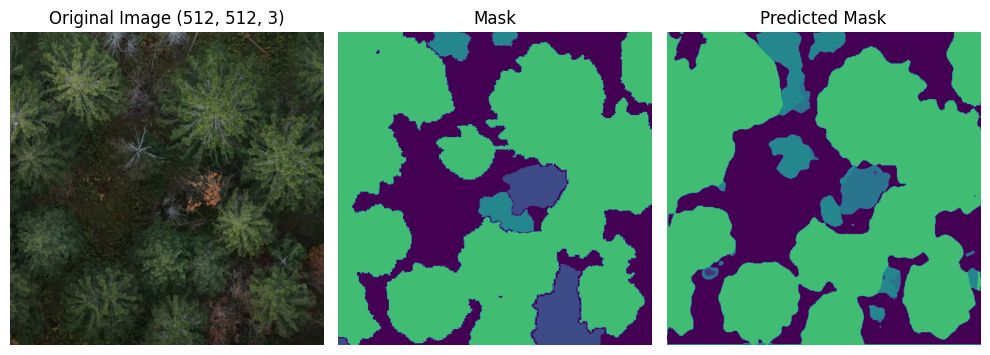

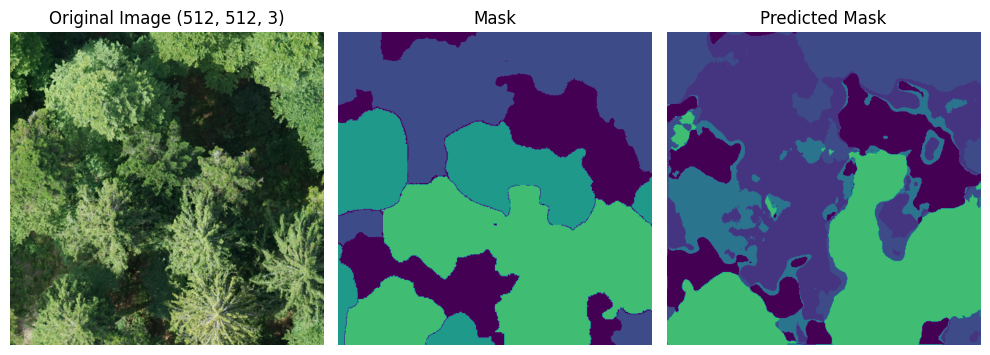

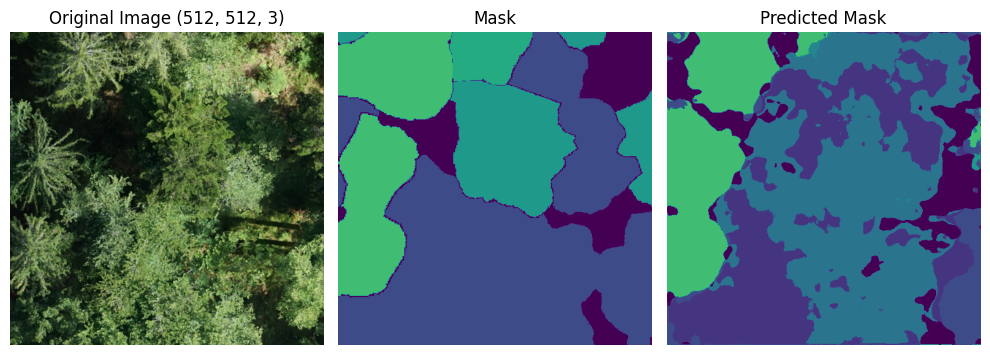

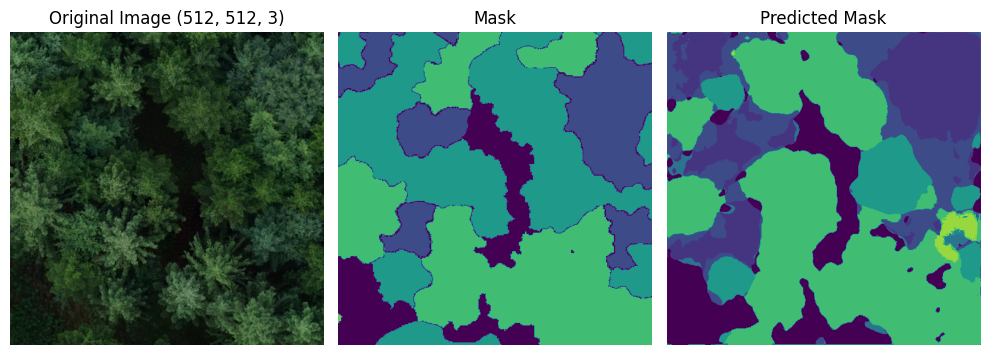

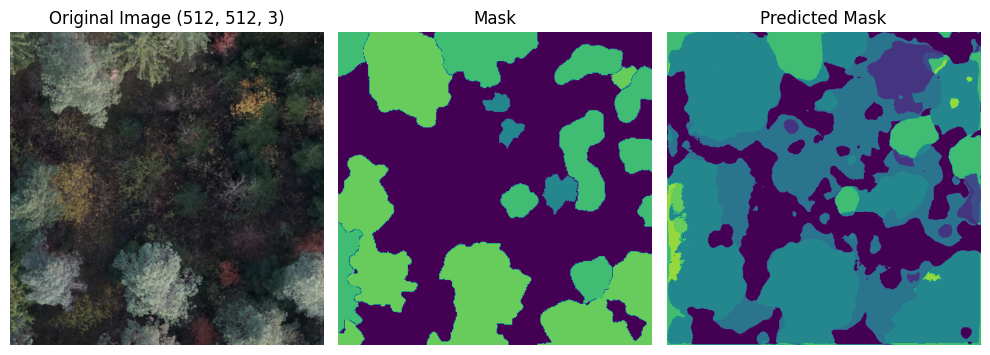

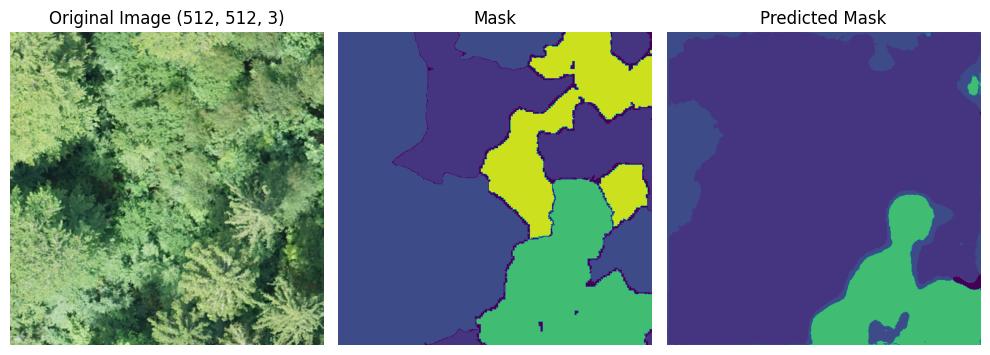

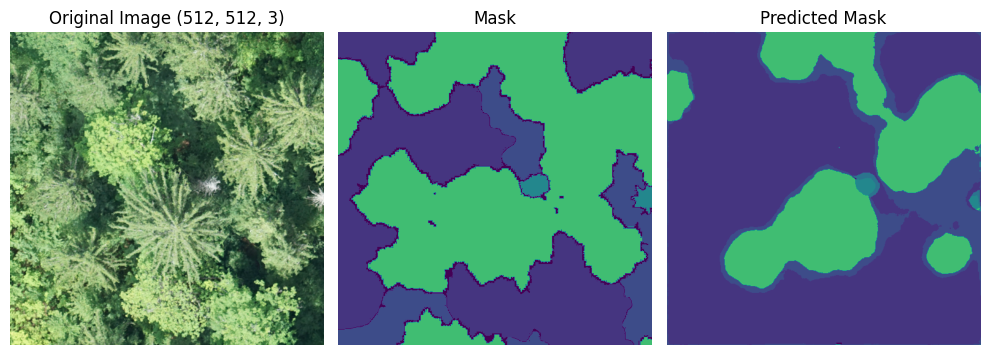

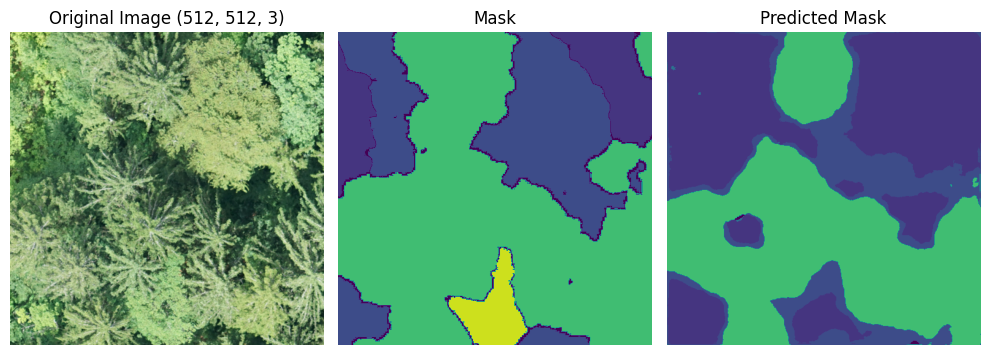

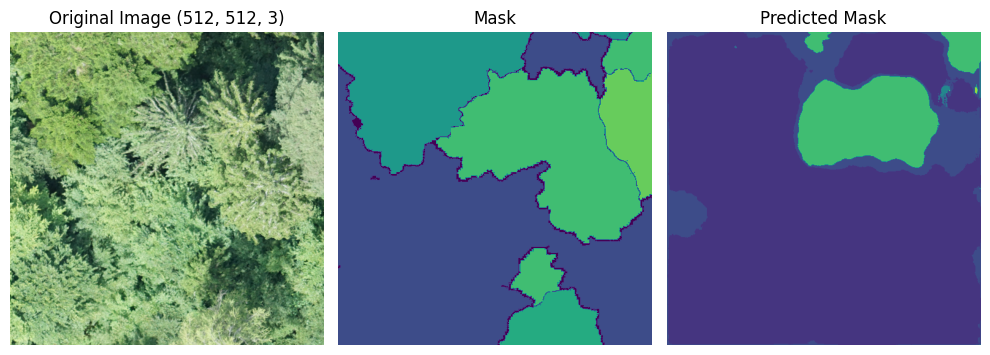

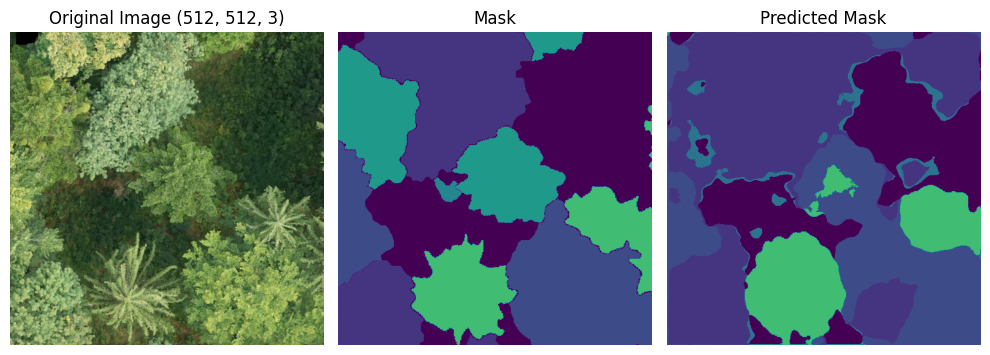

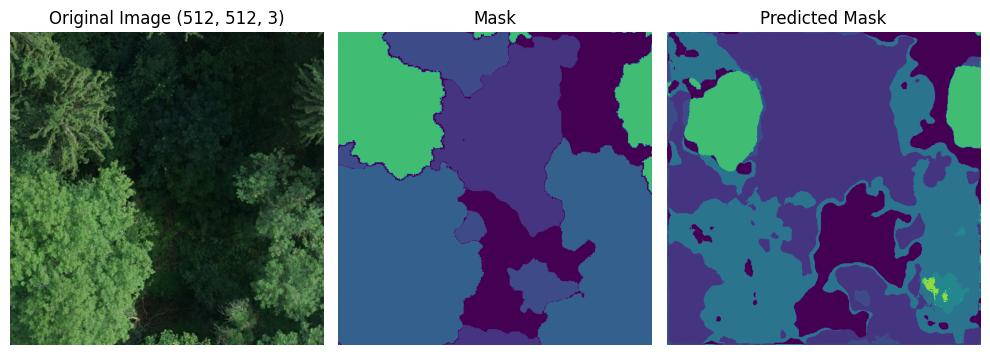

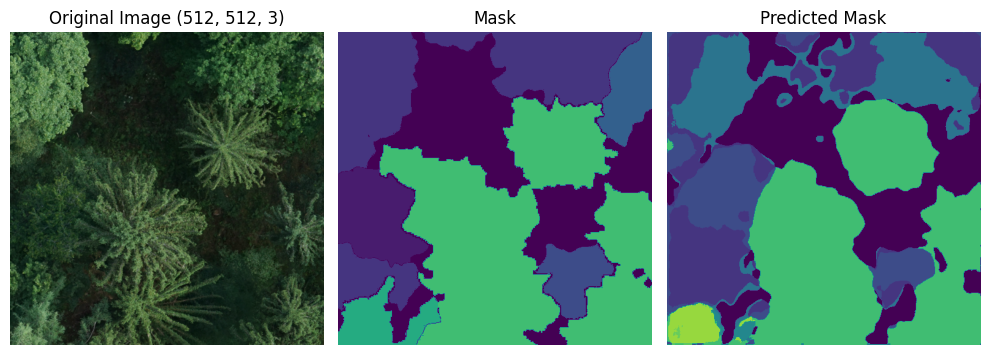

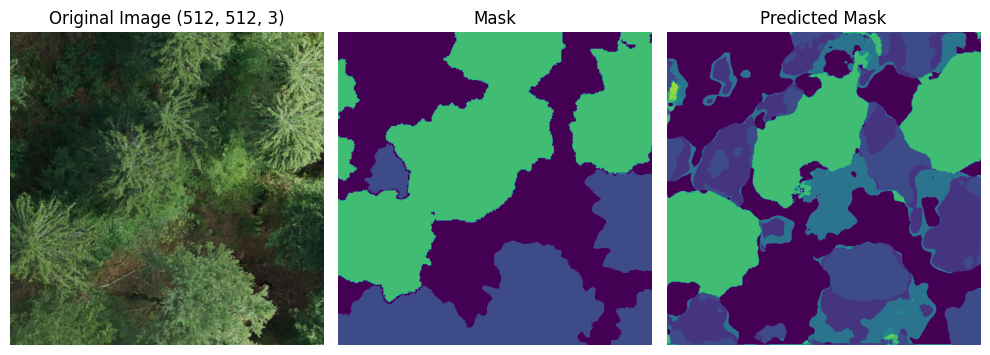

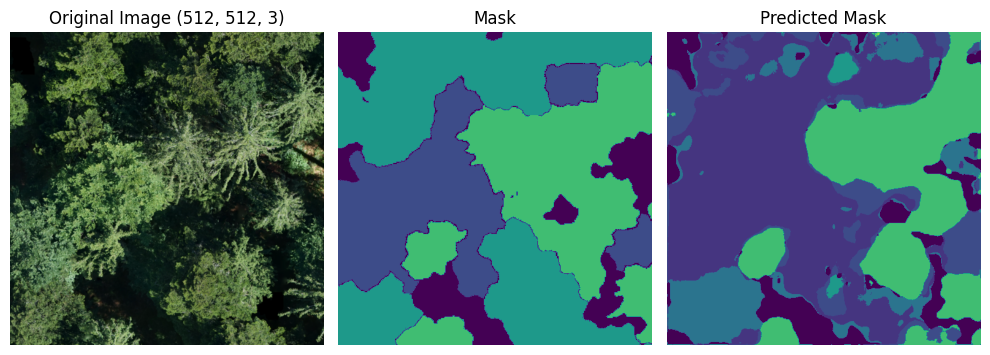

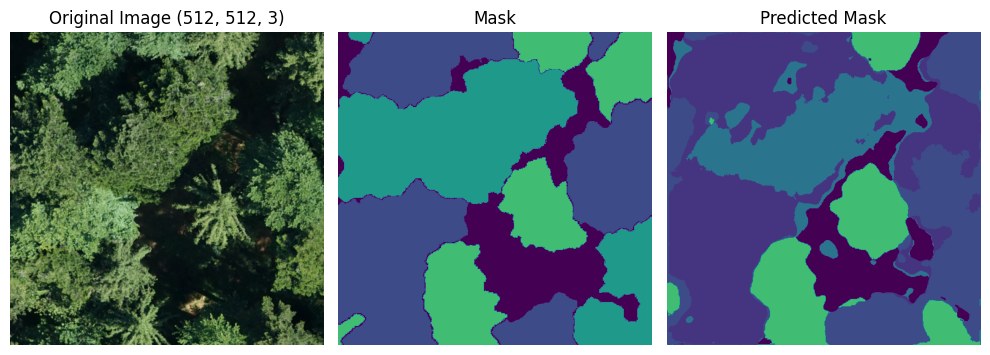

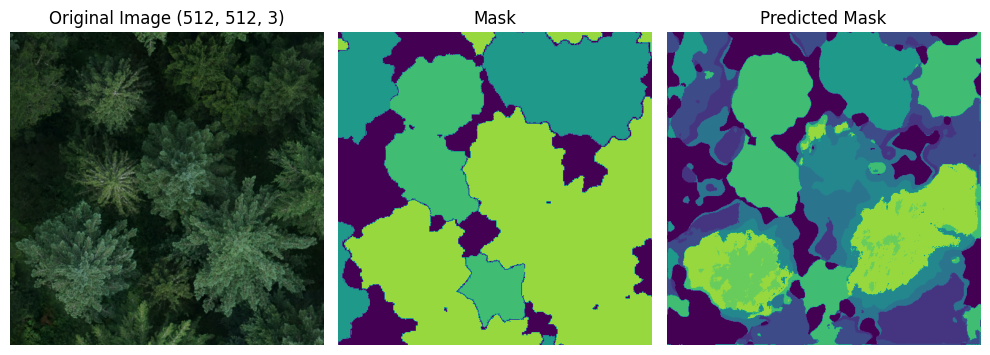

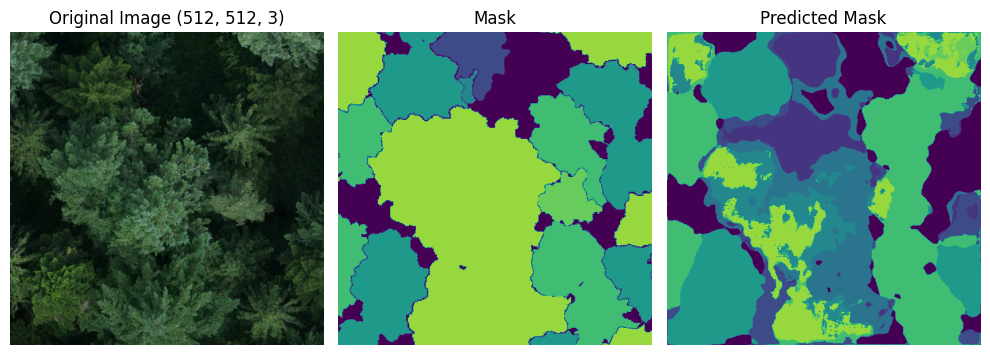

In [15]:
segment_model.eval()
predictions = []
for images, masks in test_loader:
    with torch.inference_mode():
        output = torch.nn.functional.softmax(segment_model(images.to(device)), dim=1) # Adding softmax activation to obtain class probabilities for each pixel
        predicted_masks = output.detach().cpu()
        predictions.append(predicted_masks.numpy())
    for img, mask, pred_mask in zip(images, masks, predicted_masks):
        visualise_with_masks(img, mask, pred_mask)

In [16]:
def iou_numpy(gt_mask, pred_mask):
    """
    Calculate per channel IoU in a batch of masks
    """
    gt_mask = gt_mask.transpose(0,2,3,1).astype('bool')
    pred_mask = pred_mask.transpose(0,2,3,1)
    max_values = np.max(pred_mask, axis=-1, keepdims=True)
    pred_mask_binary = (pred_mask == max_values)
    intersection = (gt_mask & pred_mask_binary).sum((1,2))
    union = (gt_mask | pred_mask_binary).sum((1,2))
    iou = (intersection + 0.00001) / (union + 0.00001)
    return iou

def evaluate_segmentation(predictions, loader):
    ious = []
    for (images, masks), pred_masks in zip(loader, predictions):
        masks = masks.cpu()
        masks = masks.numpy()
        ious.append(np.mean(iou_numpy(masks, pred_masks), axis=0))
    return np.mean(np.stack(ious), axis=0)

In [17]:
ious = evaluate_segmentation(predictions, test_loader)
# Print IoU for each class
for i, class_iou in enumerate(ious):
    print(f'IoU for class {classes[i]}: {class_iou}')

IoU for class Background: 0.44092194861431294
IoU for class Other trees: 0.950000000030931
IoU for class Maple (Acer pseudoplatanus): 0.13178858575915042
IoU for class Beech (Fagus sylvatica): 0.22567438628084427
IoU for class Ash (Fraxinus excelsior): 0.9000000000537053
IoU for class Oak (Quercus sp.): 1.860473502352307e-08
IoU for class Deadwood: 0.21501985014357122
IoU for class Fir (Abies alba): 0.5611270560701834
IoU for class Larch (Larix decidua): 0.8500000001596213
IoU for class Spruce (Picea abies): 0.5874785567342096
IoU for class Pine (Pinus sylvestris): 0.551100259952068
IoU for class Douglas fir (Pseudotsuga meziesii): 0.27632331266574695
IoU for class Birch (Betula pendula): 0.9000000000658304
